Environment:   Assume your domain is the x-y plane.   To start, you have the obstacle:  circle with radius = 4 and center = (11,11).

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<IPython.core.display.Javascript object>


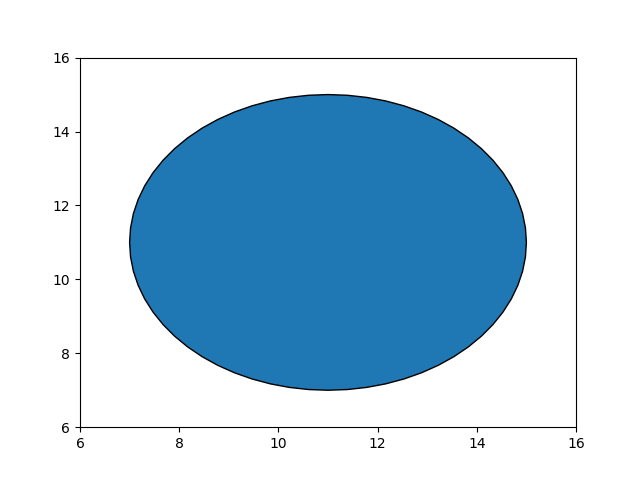

(6.0, 16.0)

In [59]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import shapely.geometry as geom
import descartes as dc

rect = geom.Polygon([ (8,6),(8,8),(6,8),(6,6)]) 
circle = geom.Point(11,11).buffer(4)

circle_patch = dc.PolygonPatch(circle)

fig,ax = plt.subplots()
ax.add_patch(circle_patch)
ax.set_xlim(6,16)
ax.set_ylim(6,16)

Using one of the planners, find (approximately) the shortest path from (9,15) to (15,9).   Plot the domain, the obstacle and the path. 

In [60]:
class Node():
    def __init__(self, xy, hfunc):
        self.neighbors = {}
        self.g = np.Inf
        self.xy = np.array(xy)
        self.hfunc = hfunc

    def __lt__(self, other):
        lt = False
        f1 = self.g+self.hfunc(self.xy)
        f2 = other.g+self.hfunc(self.xy)
        if np.abs(f1-f2) < 0.001:
            #print("almost equal")
            lt = self.g > other.g
        else:
            lt = f1 < f2
            
        #lt = f1 < f2
        return lt

    def __eq__(self, other):
        return all(self.xy == other.xy)
    
    def __call__(self):
        return self.hfunc(np.array([self.x, self.y]))
        try:
            return self.f
        except:
            self.f = self.g+self.hfunc(np.array([self.x, self.y]))
            return self.f


class Graph():
    def __init__(self, dist_func):
        self.nodes = {}
        self.dist_func = dist_func
        
    def __iadd__(self, t):
        n1 = t[0]
        n2 = t[1]
        weight = t[2]
        self.connect(n1, n2, weight)
        return graph
        
    def connect(self, n1, n2, weight):
        try:
            self.nodes[n1].neighbors[n2] = weight
        except KeyError:
            self.nodes[n1] = Node(n1, self.hfunc)
            self.nodes[n1].neighbors[n2] = weight
        try:
            self.nodes[n2].neighbors[n1] = weight
        except KeyError:
            self.nodes[n2] = Node(n2,self.hfunc)
            self.nodes[n2].neighbors[n1] = weight

    def draw(self, ax):
        for pt in self.nodes:
            node = self.nodes[pt]
            for neighbor in node.neighbors:
                ax.plot([pt[0],neighbor[0]],[pt[1], neighbor[1]],'k')
                
    def hfunc(self, node):
        return self.dist_func(node, self.goal)
        

def h_l2_dist(node, goal):
    return np.linalg.norm(node-goal)

In [61]:
import heapq

def a_star(graph, start, goal, max_iter = np.Inf):
    start_node = graph.nodes[start[0], start[1]]
    start_node.g = 0

    goal_node = graph.nodes[goal[0], goal[1]]
    graph.goal = goal

    start_node.goal = goal
    Q = [start_node]
    heapq.heapify(Q)
    searched = []
    curr_node = start_node
    count = 0
    while len(Q) > 0 and curr_node != goal_node and count < max_iter:
        curr_node = heapq.heappop(Q)
        count += 1

        searched.append(curr_node.xy)
        for neighbor in curr_node.neighbors:
            weight = curr_node.neighbors[neighbor]
            try:
                other_node = graph.nodes[neighbor]
                if curr_node.g + weight < other_node.g:
                    other_node.g = curr_node.g + weight
                    other_node.prev = curr_node
                    if other_node not in Q:
                        other_node.goal = goal
                        heapq.heappush(Q, other_node)
            except:
                pass
    if len(Q) == 0:
        print("No solution found")
        return graph, np.array([[start_node.x, start_node.y]]), np.array(searched), 0
    path = [curr_node.xy]
    path_cum_length = [0]
    path_length = 0
    while curr_node != start_node:
        path.insert(0, curr_node.prev.xy)
        path_length += np.linalg.norm(curr_node.xy-curr_node.prev.xy)
        path_cum_length.append(path_length)
        curr_node = curr_node.prev

    return graph, np.array(path), np.array(searched), np.array(path_cum_length)

<IPython.core.display.Javascript object>


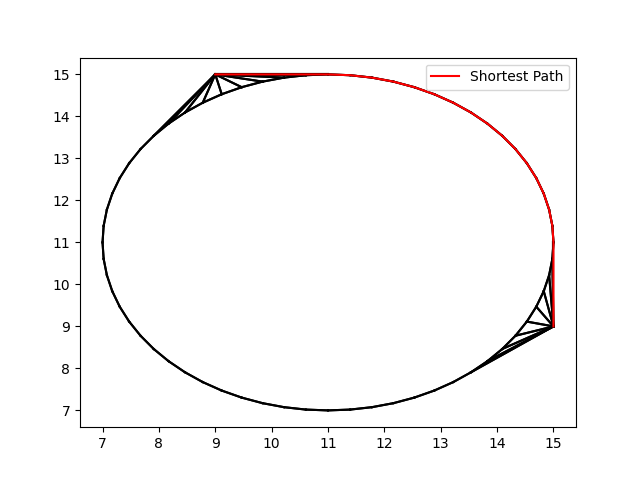

In [62]:
start_pt = (9,15)
goal_pt = (15,9)

graph = Graph(h_l2_dist)

obstacles = [circle]

vertices = [start_pt, goal_pt]
for obs in obstacles:
    vertices += [*obs.boundary.coords]

for p1 in vertices:
    for p2 in vertices:
        l = geom.LineString([p1, p2])

        if not any((l.crosses(obs) or l.within(obs)) for obs in obstacles):
            graph += (p1, p2, np.linalg.norm( np.array(p1)-np.array(p2)))

new_graph, path, searched, path_cum_length = a_star(graph, start_pt, goal_pt)

fig, ax = plt.subplots()
graph.draw(ax)
ax.plot(path[:,0], path[:,1],'r',label='Shortest Path')
plt.legend()

Assume that the path is the end-effector of a two link manipulator with arm lengths a1 = 10 and a2 = 10.    The base of the arm is (0,0).   Feed 5 to 15 of the path points into the inverse kinematics.  Plot the arms, path, and obstacle on the domain.   You may want to only plot 5.   Pick representative plots to show what the arm is doing?   Are there any issues?

<IPython.core.display.Javascript object>


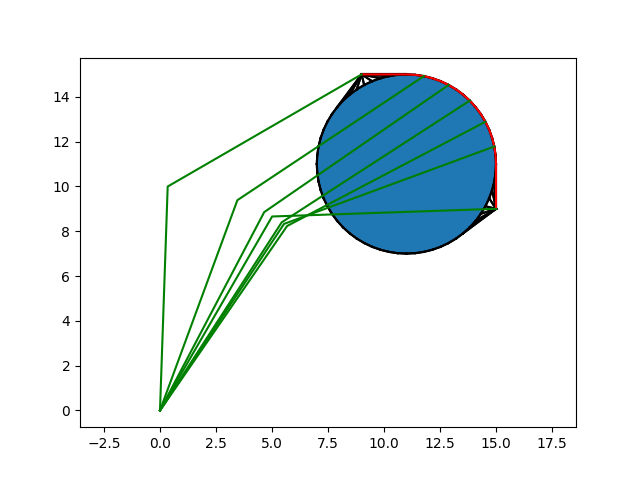

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


In [63]:
from scipy.optimize import fsolve

a1 = 10
a2 = 10
base = (0,0)

def fk(thetas):
    t1 = thetas[0]
    t2 = thetas[1]
    x1 = a1*np.cos(t1)
    y1 = a1*np.sin(t1)
    
    x2 = x1 + a2*np.cos(t1+t2)
    y2 = y1 + a2*np.sin(t1+t2)
    
    return np.array([(0,0),(x1,y1),(x2,y2)])

def ik(xy, t_guess=np.array((0,0))):
    def diff(thetas):
        base, j1, j2 = fk([thetas[0], thetas[1]])
        return j2 - xy
    res = fsolve(diff, t_guess)
    return res


base, j1, j2 = fk([0.2,-0.1])

#print(ik(j2))
    
thetas = np.array([0,0])
bases = []
j1s = []
j2s = []

fig, ax = plt.subplots()
patches = []
for obs in obstacles:
    patch = dc.PolygonPatch(obs)
    patches.append(patch)
    ax.add_patch(patch)
ax.set_xlim(0,16)
ax.set_ylim(0,16)
graph.draw(ax)
ax.plot(path[:,0],path[:,1],'r')
path_q = []
for i in range(0,len(path),3):
    pt = path[i]
    thetas = ik(pt,thetas)
    path_q.append(thetas)
    #base,j1,j2 = fk(thetas)
    res = fk(thetas)
    bases.append(base)
    j1s.append(j1)
    j2s.append(j2)
    ax.plot(res[:,0],res[:,1],'g')

ax.axis('equal')
path_q = np.array(path_q)

    

Oh No!!! The manipulator is going through the obstacle. The horror!

Write some code to determine what the obstacle looks like in configuration space.  Don't just focus on the end-effector; you also need to consider intermediate link - obstacle collisions.    Plot the obstacle in config space.    Plot the configuration space path on the previous plot.  What happens if you add quadrant 3 as an obstacle?

In [64]:
def turn_left_till_free(pos, theta, ds, obs):
    dir_vec = np.array([np.cos(theta), np.sin(theta)])
    new_pos = pos + dir_vec*ds
    # turn left until we see free space
    while collision(new_pos, obs):
        time_since_collision = 0
        theta += 0.1
        dir_vec = np.array([np.cos(theta), np.sin(theta)])
        new_pos = pos + dir_vec*ds
        # ax2.plot(new_pos[0], new_pos[1], 'g.')
    return theta


def turn_right_till_wall(pos, theta, ds, obs):
    dir_vec = np.array([np.cos(theta), np.sin(theta)])
    new_pos = pos + dir_vec*ds
    # turn left until we see free space
    while not collision(new_pos, obs):
        time_since_collision = 0
        theta -= 0.1
        dir_vec = np.array([np.cos(theta), np.sin(theta)])
        new_pos = pos + dir_vec*ds
        # ax2.plot(new_pos[0], new_pos[1], 'r.')
    return theta


def step_forward(pos, theta, ds, path_length):
    dir_vec = np.array([np.cos(theta), np.sin(theta)])
    new_pos = pos + dir_vec*ds
    pos = new_pos
    path_length += ds
    if path_length > 100:
        raise RuntimeError
    return pos, path_length


def collision(thetas, obstacle):
    joints = fk(thetas)
    manipulator = geom.LineString(joints)
    return manipulator.intersects(obstacle)


def find_boundary(obs):
    pos = np.array([0., 0.])
    goal_pt = np.array([2*np.pi, 0])
    mode = "init"
    ds = 0.1
    path_length = 0
    theta = 0
    prev_mode = "none"
    while np.linalg.norm(pos-goal_pt) > ds:
        should_yield = True
        if mode != prev_mode:
            # print("mode: {} -> {}, {}, {}".format(prev_mode, mode, pos, pos-goal_pt))
            prev_mode = mode

        if mode == "goal":
            should_yield = False
            dir_vec = np.array([1, 0])
            theta = 0
            new_pos = pos + dir_vec*ds

            if collision(new_pos, obs):
                mode = "wall_start"

            else:
                pos, path_length = step_forward(
                    pos, theta, ds, path_length)
        elif mode == "wall_start":
            theta = turn_right_till_wall(pos, theta, ds, obs)
            theta = turn_left_till_free(pos, theta, ds, obs)
            wall_start_pos = pos
            pos, path_length = step_forward(
                pos, theta, ds*1.1, path_length)
            mode = "wall"
        elif mode == "wall":
            theta = turn_left_till_free(pos, theta, ds, obs)
            theta = turn_right_till_wall(pos, theta, ds, obs)
            theta += 0.1
            old_pos = pos.copy()
            pos, path_length = step_forward(pos, theta, ds, path_length)

            curr_dist = np.linalg.norm(pos-goal_pt)

            if np.linalg.norm(pos-wall_start_pos) < ds:
                mode = "cross_obstacle_then_goal"
            if np.linalg.norm(pos - np.array([0, 2*np.pi+ds]) - wall_start_pos) < ds:
                pos = wall_start_pos + np.array([0, 2*np.pi+ds])
                mode = "cross_obstacle_then_wall"
            if np.linalg.norm(pos + np.array([0, 2*np.pi+ds]) - wall_start_pos) < ds:
                pos = wall_start_pos - np.array([0, 2*np.pi+ds])
                mode = "goal"
        elif mode == "cross_obstacle_then_wall":
            theta = 0
            dir_vec = np.array([1, 0])
            new_pos = pos + dir_vec*ds

            pos, path_length = step_forward(pos, theta, ds, path_length)
            if not collision(pos, obs):
                mode = "wall_start"
        elif mode == "cross_obstacle_then_goal":
            should_yield = False
            theta = 0
            dir_vec = np.array([1, 0])
            new_pos = pos + dir_vec*ds

            pos, path_length = step_forward(pos, theta, ds, path_length)

            if not collision(pos, obs):
                mode = "goal"
        elif mode == "init":
            should_yield = False
            theta = 0
            dir_vec = np.array([1, 0])
            new_pos = pos + dir_vec*ds

            pos, path_length = step_forward(pos, theta, ds, path_length)
            if not collision(pos, obs):
                mode = "goal"
                goal_pt = np.array([new_pos[0]+2*np.pi, 0])
        if should_yield:
            yield pos

In [65]:
circle = geom.Point(11, 11).buffer(4)
quad_3 = geom.Polygon(np.array(
    [[-0.000001, -0.000001], [-21, -0.000001], [-21, -21], [-0.0000001, -21]]))
circle_2 = geom.Point(5, 5).buffer(4)
circle_3 = geom.Point(5, 0).buffer(1)

<IPython.core.display.Javascript object>


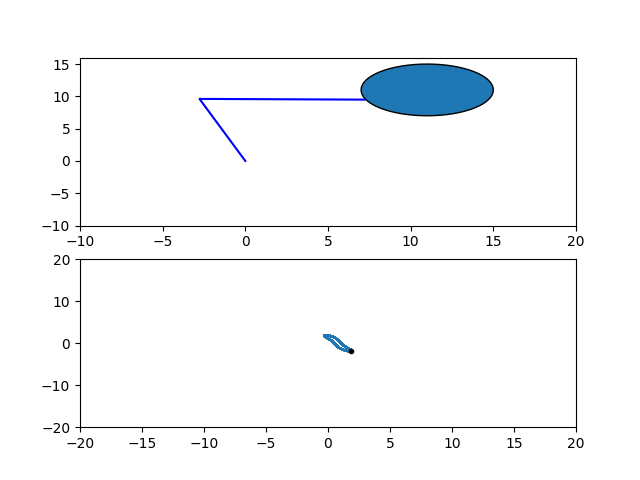

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


In [66]:
boundary_t1 = []
boundary_t2 = []
def anim_func(data):
    pos = data
    boundary_t1.append(pos[0])
    boundary_t2.append(pos[1])
    joints = fk(pos)
    l1.set_data(joints[:, 0], joints[:, 1])
    p2.set_data(pos[0], pos[1])
    l2.set_data(boundary_t1, boundary_t2)


obs = circle
fig, [ax1, ax2] = plt.subplots(2, 1)
patch = dc.PolygonPatch(obs)
ax1.add_patch(patch)

l1, = ax1.plot([], [], 'b')
l2, = ax2.plot([], [])
p2, = ax2.plot([], [], 'k.')

ax1.set_xlim(-10, 20)
ax1.set_ylim(-10, 16)
# ax1.axis('equal')

ax2.set_xlim(-20, 20)
ax2.set_ylim(-20, 20)

y = find_boundary(circle)
animation = anim.FuncAnimation(fig, anim_func, y, interval=20)
plt.show()

<IPython.core.display.Javascript object>


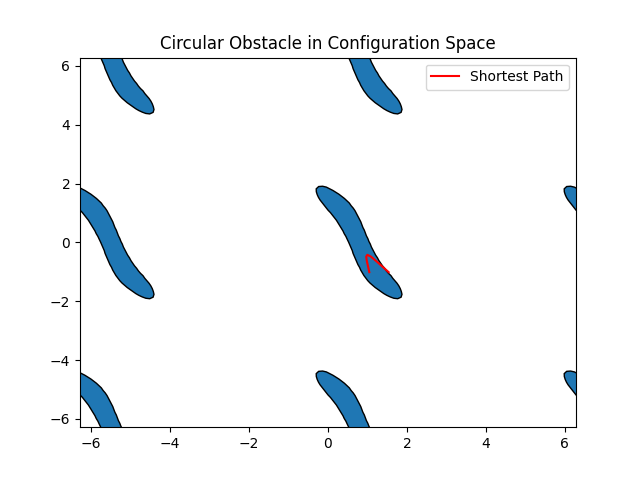

In [69]:
obstacles = [circle]


boundary_pts = []
for obs in obstacles:
    y = find_boundary(obs)
    boundary = [pos for pos in y]
    boundary_pts.append(np.array(boundary))

offsets = [2*np.pi, 0, -2*np.pi]
# offsets = [0]
fig, ax = plt.subplots()
n = 2
plt.xlim([-n*np.pi, n*np.pi])
plt.ylim([-n*np.pi, n*np.pi])
for boundary in boundary_pts:
    for x_offset in offsets:
        for y_offset in offsets:
            new_bound = np.array(
                [boundary[:, 0]+x_offset, boundary[:, 1]+y_offset]).T
            polygon = geom.Polygon(new_bound)
            patch = dc.PolygonPatch(polygon)
            ax.add_patch(patch)

ax.plot(path_q[:,0], path_q[:,1],'r',label="Shortest Path")
plt.title("Circular Obstacle in Configuration Space")
plt.legend()


<IPython.core.display.Javascript object>


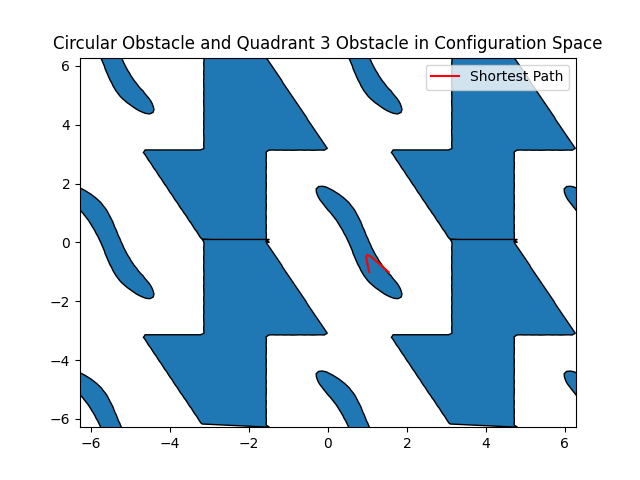

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


In [71]:
obstacles = [circle, quad_3]


boundary_pts = []
for obs in obstacles:
    y = find_boundary(obs)
    boundary = [pos for pos in y]
    boundary_pts.append(np.array(boundary))

offsets = [2*np.pi, 0, -2*np.pi]
# offsets = [0]
fig, ax = plt.subplots()
n = 2
plt.xlim([-n*np.pi, n*np.pi])
plt.ylim([-n*np.pi, n*np.pi])
for boundary in boundary_pts:
    for x_offset in offsets:
        for y_offset in offsets:
            new_bound = np.array(
                [boundary[:, 0]+x_offset, boundary[:, 1]+y_offset]).T
            polygon = geom.Polygon(new_bound)
            patch = dc.PolygonPatch(polygon)
            ax.add_patch(patch)

ax.plot(path_q[:,0], path_q[:,1],'r',label="Shortest Path")
plt.title("Circular Obstacle and Quadrant 3 Obstacle in Configuration Space")
plt.legend()

Find the points in config space that correspond to (9,15) and (15,9).   Using the obstacle you just computed.  Find a minimal path between the two computed points.  

Following the path you computed in #4, what is the path of the end-effector in the workspace.   Create a second plot that shows some sample arm configurations while moving along the path. 

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<IPython.core.display.Javascript object>


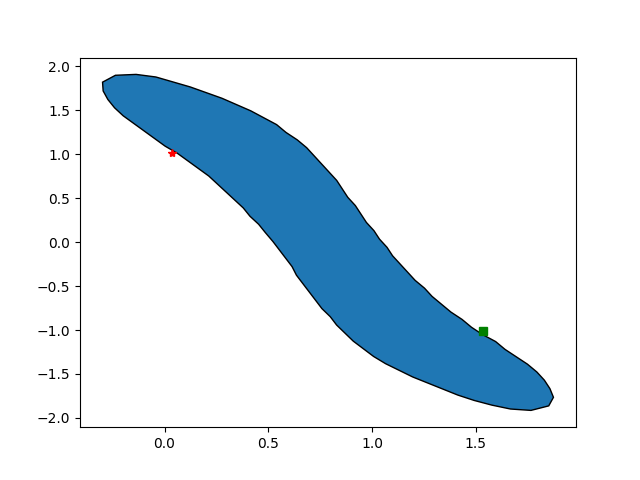

In [72]:
from scipy.interpolate import interp1d

graph = Graph(h_l2_dist)



y = find_boundary(circle)
circle_boundary = np.array([pos for pos in y])
circle_q = geom.Polygon(circle_boundary)
circle_patch = dc.PolygonPatch(circle_q)

start_thetas = tuple(ik(start_pt))
if geom.Point(start_thetas).intersects(circle_q):
    new_start = (start_thetas[0] + 2* start_thetas[1], -start_thetas[1])
    start_thetas = tuple(ik(goal_pt, new_start))
goal_thetas = tuple(ik(goal_pt))
if geom.Point(goal_thetas).intersects(circle_q):
    new_goal = (goal_thetas[0] + 2*goal_thetas[1], -goal_thetas[1])
    goal_thetas = tuple(ik(goal_pt, new_goal))
fig, ax = plt.subplots()
ax.add_patch(circle_patch)
ax.plot(start_thetas[0], start_thetas[1],'gs')
ax.plot(goal_thetas[0], goal_thetas[1], 'r*')


In [73]:
obstacles_q = [circle_q]

vertices = [start_thetas, goal_thetas]
for obs in obstacles_q:
    vertices += [*obs.boundary.coords]
    
graph = Graph(h_l2_dist)
for p1 in vertices:
    for p2 in vertices:
        l = geom.LineString([p1, p2])

        if not any((l.crosses(obs) or l.within(obs)) for obs in obstacles_q):
            graph += (p1, p2, np.linalg.norm( np.array(p1)-np.array(p2)))

<IPython.core.display.Javascript object>


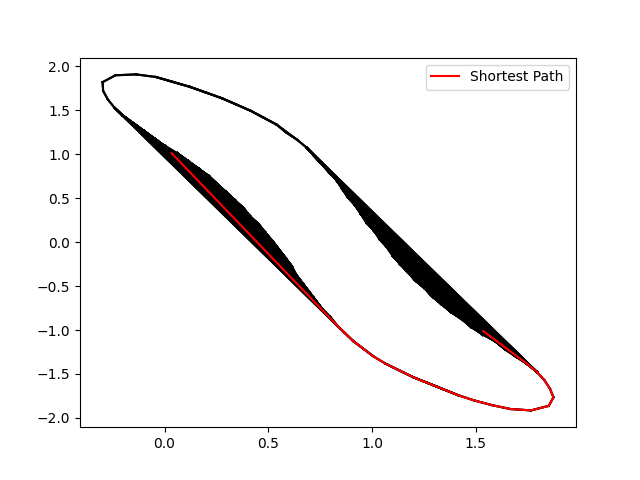

<IPython.core.display.Javascript object>


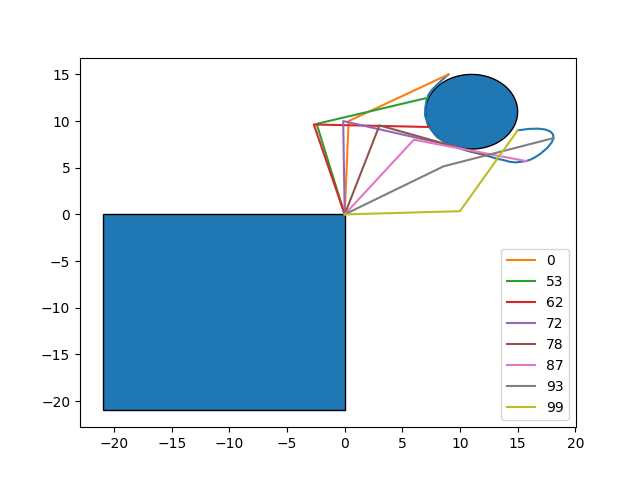

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


In [74]:
new_graph, path_q, searched, path_cum_length_q = a_star(graph, start_thetas, goal_thetas)

fig, ax = plt.subplots()
graph.draw(ax)
ax.plot(path_q[:,0], path_q[:,1],'r',label='Shortest Path')
plt.legend()

interpolator = interp1d(path_cum_length_q, path_q, 'linear',axis=0)

interp_x = np.linspace(0, path_cum_length_q[-1], 100)
interp_path_q = interpolator(interp_x)

fig2, ax2 = plt.subplots()

patches = []
for obs in obstacles:
    patch = dc.PolygonPatch(obs)
    patches.append(patch)
    ax2.add_patch(patch)
    
path = []
for pt in interp_path_q:
    path.append(fk(pt))
path = np.array(path)

ax2.plot(path[:,2,0],path[:,2,1])
joints = path[0]
ax2.plot(joints[:,0],joints[:,1],label='0')
last_plotted = joints
for i in range(1,len(path)):
    joints = path[i]
    if np.linalg.norm(joints[2]-last_plotted[2]) > 3:
        ax2.plot(joints[:,0],joints[:,1], label=str(i))
        last_plotted = joints
plt.legend()

In order to simplify the solution to start with, I'm only going to consider intersections with the second link. For this problem, that is totally adequate because the obstacle will never touch the first link. We can parameterize the intersection point on the second arm by creating an auxiliary variable, $s$ that will vary between 0 and 1. When $s=0$ the point will be at the joint between arms 1 and 2. When $s=1$, the point will be at the end effector. With this approach, we can define any point within the workspace, $q$, with the following equations:

$$ p_1 = \left< a_1 cos(\theta_1), a_1 sin(\theta_1) \right> $$
$$ p_2 = p_1 + \left< a_2 cos(\theta_1 + \theta_2), a_2 sin(\theta_1 + \theta_2)\right> $$
$$ q(\theta_1, \theta_2, s) = s \cdot p_2 + (1-s)\cdot p_1 $$

For a given point, $q$, we can now define all the configurations that intersect with that point as the set of $\theta_1$, $\theta_2$, $0<=s<=1$ that solves the above equation.

Once we have found one solution to this equation, we can discover others by perturbing $\theta_1$, $\theta_2$, and $s$ such that the total derivative of q with respect to time is zero. The Jacobian represents the partial derivatives of this equation with respect to each of the independent variables, thus the nullspace of the Jacobian represents the direction in which we should travel in order to hold $q$ constant while varying the independent variables. Put another way, we want to solve the following differential equation:
$$ \frac{\partial q}{\partial \theta_1} \frac{d\theta_1}{d t} + \frac{\partial q}{\partial \theta_2} \frac{d\theta_2}{d t} + \frac{\partial q}{\partial s} \frac{ds}{d t} = 0$$

to find $\theta_1(t)$, $\theta_2(t)$, and $s(t)$

Thankfully this is easily done numerically using the `scipy.integrate.solve_ivp()` function which will numerically solve an initial value problem. We simply have to define a function which takes in the state, $[\theta_1, \theta_2, s]$ and returns $[\dot \theta_1, \dot \theta_2, \dot s]$.

In order to avoid computing a bunch of partial derivatives by hand, in the following section I create an autodifferentiation class compatible with numpy. Once that has been done, I define the `fk_arm()` function to do the forward_kinematics according to the definition of $q$ above. The `fk_arm_jac()` function then uses the autodifferentiation class to compute the Jacobian of $q$. Finally, the `null_deriv()` function computes the nullspace of the Jacobian, correcting for sign flips, and allowing either forward or backward traversal via the `direction` argument.

Once all that has been defined, we can pass `null_deriv()` to the solve_ivp function to traverse the level set. We also define the `reached_p1()` and `reached_p2()` functions to enable solve_ivp to terminate when it has traversed all the way to the end of the arm.

/tmp/ipykernel_24139/2587986453.py:60: RuntimeWarning: divide by zero encountered in log
  newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)
/tmp/ipykernel_24139/2587986453.py:60: RuntimeWarning: invalid value encountered in double_scalars
  newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)
/tmp/ipykernel_24139/2587986453.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)


<IPython.core.display.Javascript object>


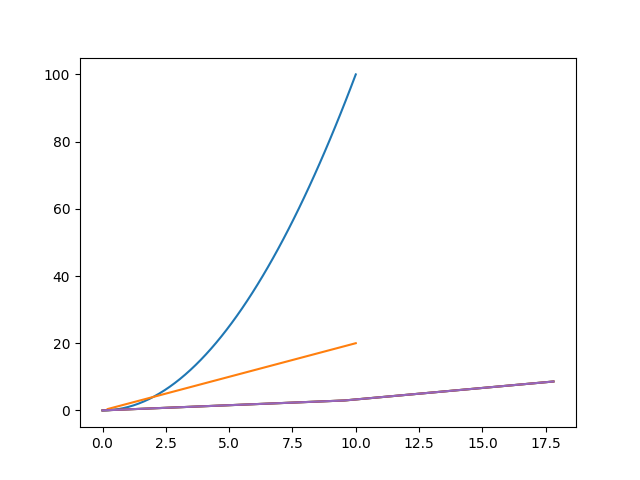

In [98]:
import numpy as np

class D:
    
    def __init__(self, v, d=0):
        self.v = v
        self.d = d
        
    def __add__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = self.v + other.v
        newd = self.d + other.d
        
        return D(newv, newd)
    def __radd__(self, other):
        
        return self.__add__(other) 
    
    def __mul__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = self.v * other.v
        newd = self.v*other.d + self.d*other.v
        
        return D(newv, newd)
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __sub__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = self.v - other.v
        newd = self.d - other.d
        
        return D(newv, newd)
    
    def __rsub__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = other.v - self.v
        newd = other.d - self.d
        
        return D(newv, newd)
    
    def __pow__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = self.v**other.v
        newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)
        
        return D(newv, newd)
    
    def __str__(self):
        return "({},{})".format(self.v, self.d)
    
    def __repr__(self):
        return self.__str__()
    
    def sin(self):
        newv = np.sin(self.v)
        newd = np.cos(self.v)*self.d
        
        return D(newv,newd)
    
    def cos(self):
        newv = np.cos(self.v)
        newd = -np.sin(self.v)*self.d
        return D(newv, newd)
    
    def sqrt(self):
        newv = np.sqrt(self.v)
        newd = 0.5* self.d/newv
    
x = np.array([D(i,1) for i in np.linspace(0,10)])

y = x**2
# y = np.sin(x)

plt.figure()
plt.plot([i.v for i in x],[i.v for i in y])
plt.plot([i.v for i in x], [i.d for i in y])



In [91]:
from scipy.integrate import solve_ivp
from scipy.linalg import null_space

def fk_arm(data):
    t1 = data[0]
    t2 = data[1]
    s = data[2]
    #s = -0.5*np.cos(data[2])+0.5
    
    p1 = np.array([a1*np.cos(t1), a1*np.sin(t1)])
    p2 = p1 + np.array([a2*np.cos(t1+t2), a2*np.sin(t1+t2)])
    
    return p1*(1-s) + p2*s

def fk_arm_jac(data):
    J = []
    for i in range(len(data)):
        newdata = []
        for j in range(len(data)):
            temp = D(data[j])
            if i == j:
                temp.d = 1
            else:
                temp.d = 0
            newdata.append(temp)
        dpdi = fk_arm(newdata)
        J.append([dp.d for dp in dpdi])
    return np.array(J).T

def null_deriv(t, data, direction):
    J = fk_arm_jac(data)
    ns = null_space(J)[:,0]
    ns *= np.sign(ns[0])
    if direction == 'f':
        return ns
    else:
        return -ns

data = [0.3, 0.3, 0.3]
p = fk_arm(data)
joints = fk(data)

plt.plot(joints[:,0], joints[:,1])
plt.scatter(p[0], p[1])

def reached_p1(t,data, direction):
    return data[2]
reached_p1.terminal = True

def reached_p2(t,data, direction):
    return data[2] - 1
reached_p2.terminal = True

t_f = 7
data0 = np.array([*ik(p), 0.9999])
res = solve_ivp(null_deriv, (0,t_f), data0, args=("b"), t_eval=np.arange(0,t_f,0.02), events=(reached_p1, reached_p2))

<IPython.core.display.Javascript object>


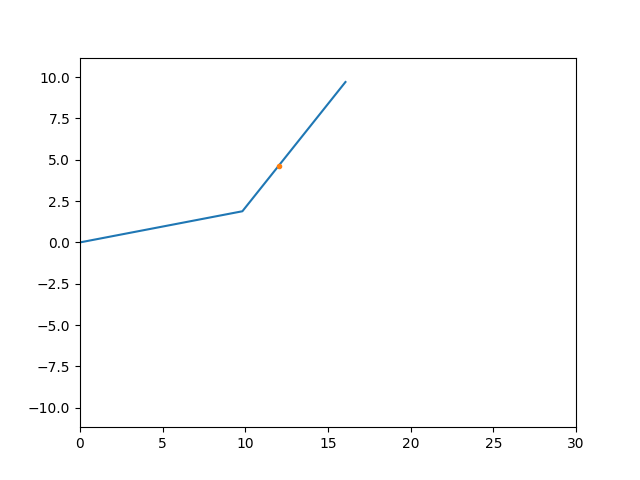

In [92]:
fig, ax = plt.subplots()

joints = fk(res.y.T[0])
l1, = ax.plot(joints[:,0],joints[:,1])
p1, = ax.plot(p[0],p[1],'.')

ax.axis('equal')
ax.set_ylim(-20,20)
ax.set_xlim(0,30)


def anim_func(i):
    print(i)
    data = res.y.T[i]
    joints = fk(data)
    p = fk_arm(data)
    l1.set_data(joints[:,0], joints[:,1])
    p1.set_data(p[0],p[1])

    return l1, p1

func = animation.FuncAnimation(fig, anim_func, frames=len(res.y.T),interval=20)
plt.show()

<IPython.core.display.Javascript object>


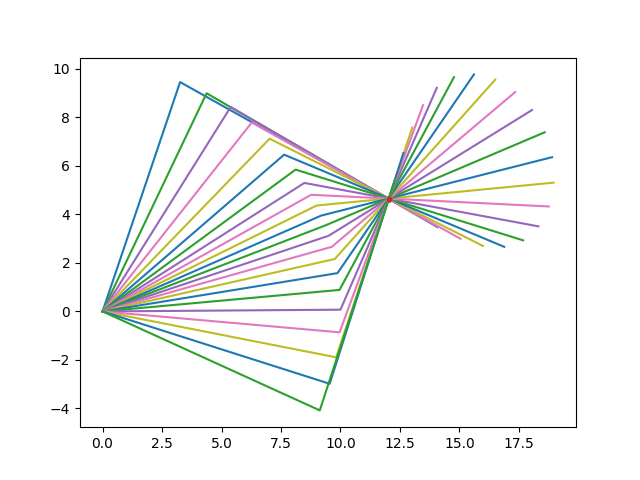

In [93]:
def draw_manipulator(data, ax):
    joints = fk(data)
    p = fk_arm(data)
    l1 = ax.plot(joints[:,0],joints[:,1])
    p1 = ax.plot(p[0],p[1],'.')

fig, ax = plt.subplots()
for i in range(0,len(res.y.T), 10):
    data = res.y.T[i]
    draw_manipulator(data, ax)
    

Now we will try to extend the previous work to trace out the edge of a shape with the manipulator. We will assume a single convex obstacle to begin with and reduce the scope even further to be only two connected edges on the convex obstacle. This should then be extensible to an iterative approach that considers three sequential vertices along the edge of the convex obstacle. The three points we will choose are (5,20), (10,7.5), and (20,12). These points will guarantee that the manipulator has to contact both with the edge of the link and with the end-effector while traversing the obstacle.

<IPython.core.display.Javascript object>


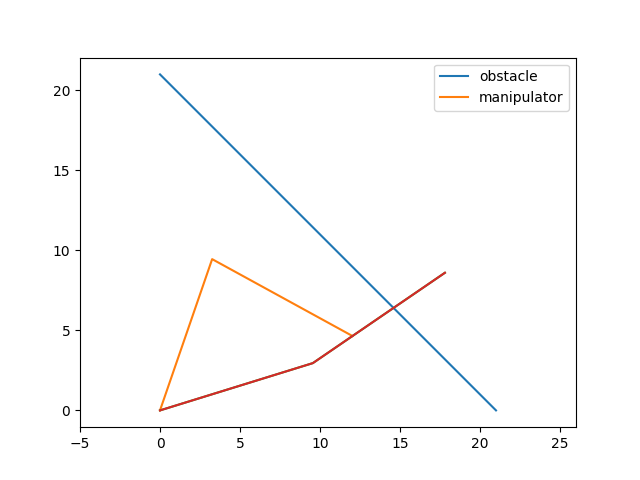

(-1.05, 22.05, -1.05, 22.05)

In [94]:
fig, ax = plt.subplots()

obs_pts = np.array([[21,0],[0,21]])
obs, = ax.plot(obs_pts[:,0], obs_pts[:,1], label='obstacle')
ax.plot(joints[:,0],joints[:,1], label='manipulator')
plt.legend()
plt.axis('equal')

To traverse a straight line with the end-effector, we can parameterize a point along the obstacle with the two endpoints as follows:

$$ p_l = q_1 \cdot (1-r) + q_2 \cdot r $$

This must be equal to the position of the end effector:

$$ p_1 = \left< a_1 cos(\theta_1), a_1 sin(\theta_1) \right> $$
$$ p_2 = p_1 + \left< a_2 cos(\theta_1 + \theta_2), a_2 sin(\theta_1 + \theta_2)\right> $$

Setting them equal and moving everything to the left hand side, we get the following equation:

$$ q(\theta_1, \theta_2, r) = p_2 - p_l = 0 $$

Just as before we can compute the Jacobian and travel in the direction of the null-space in order to move along the boundary.

<IPython.core.display.Javascript object>


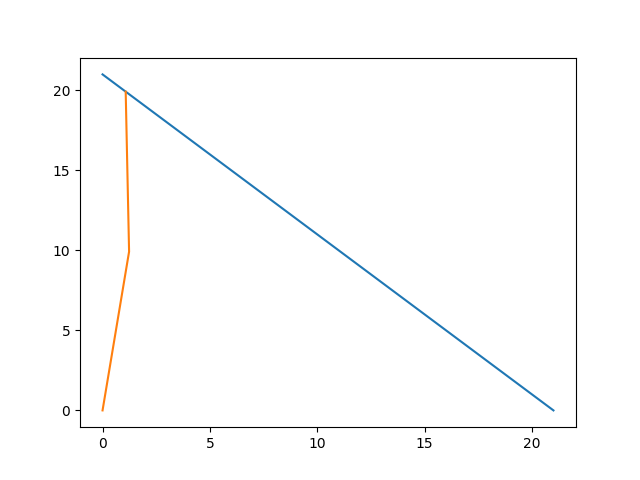

p2:[(1.0779531283859347,-19.922047625831098)
 (19.922047625831098,1.0779531283859347)]
pl:[(1.0779525956181877,0.0) (19.922047404381814,0.0)]
ret:[(2.8384147227558137e-13,nan) (4.903978529522383e-14,nan)]
retsum:(3.328812575708052e-13,nan)
retsqrt:None


/tmp/ipykernel_24139/2587986453.py:60: RuntimeWarning: invalid value encountered in log
  newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)


AttributeError: 'NoneType' object has no attribute 'd'

In [101]:
from scipy.optimize import minimize

q1 = np.array([0,21])
q2 = np.array([21,0])
def fk_end(data):
    t1 = data[0]
    t2 = data[1]
    r = data[2]
    pl = q1*(1-r) + q2*r
#     print("t1:{}".format(t1))
#     print("pl:{}".format(pl))
    p1 = np.array([a1*np.cos(t1), a1*np.sin(t1)])
    p2 = p1 + np.array([a2*np.cos(t1+t2), a2*np.sin(t1+t2)])
    print("p2:{}".format(p2))
    print("pl:{}".format(pl))

    ret = (pl-p2)**2
    print("ret:{}".format(ret))
    ret = np.sum(ret)
    print("retsum:{}".format(ret))
    ret = np.sqrt(ret)
    print("retsqrt:{}".format(ret))
    return ret
#     return np.linalg.norm(pl-p2)

# def ik_end(xy, t_guess=np.array((0,0))):
#     def diff(thetas):
        
#         return j2 - xy
#     res = fsolve(diff, t_guess)
#     return res

def fk_end_jac(data):
    J = []
    for i in range(len(data)):
        newdata = []
        for j in range(len(data)):
            temp = D(data[j])
            if i == j:
                temp.d = 1
            else:
                temp.d = 0
            newdata.append(temp)
        dpdi = fk_end(newdata)
        J.append(dpdi.d)
    return np.array(J).T

def null_end_deriv(t, data, direction):
    J = fk_end_jac(data)
    ns = null_space(J)[:,0]
    ns *= np.sign(ns[0])
    if direction == 'f':
        return ns
    else:
        return -ns

data = [0.3, 0.3, 0.3]
joints = fk(data)

plt.plot(joints[:,0], joints[:,1])

# data0 = minimize(fk_end, x0 = [np.pi/2,0.2, 0.5])
# print(data0)
fig, ax = plt.subplots()
joints = fk(data0.x)
obs_pts = np.array([[21,0],[0,21]])
obs, = ax.plot(obs_pts[:,0], obs_pts[:,1], label='obstacle')
ax.plot(joints[:,0],joints[:,1], label='manipulator')

print(fk_end_jac(data0.x))
print(null_end_deriv(0,data0.x,'f'))

t_f = 7
res = solve_ivp(null_end_deriv, (0,t_f), data0.x, args=("b"), t_eval=np.arange(0,t_f,0.02))
print(res)

<IPython.core.display.Javascript object>


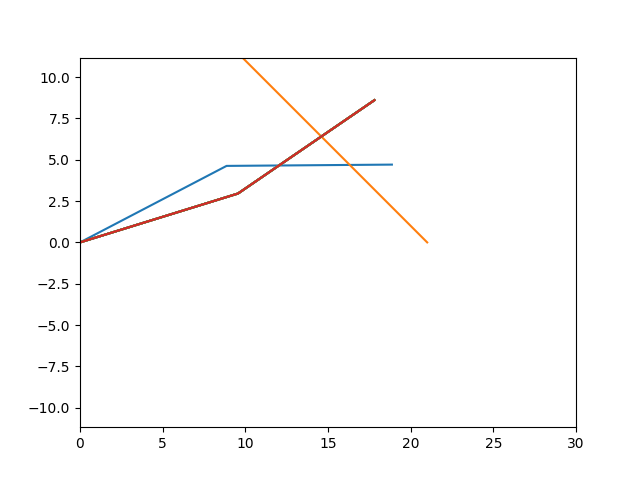

In [77]:
fig, ax = plt.subplots()

joints = fk(res.y.T[0])
l1, = ax.plot(joints[:,0],joints[:,1])
obs_pts = np.array([[21,0],[0,21]])
obs, = ax.plot(obs_pts[:,0], obs_pts[:,1], label='obstacle')

ax.axis('equal')
ax.set_ylim(-20,20)
ax.set_xlim(0,30)


def anim_func(i):
    print(i)
    data = res.y.T[i]
    joints = fk(data)
    l1.set_data(joints[:,0], joints[:,1])
    

    return l1

func = animation.FuncAnimation(fig, anim_func, frames=len(res.y.T),interval=20)
plt.show()